In [45]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models
from torchvision import transforms
from torchvision.models import VGG16_Weights
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)

device = cuda


In [3]:
g_df = pd.read_csv('/kaggle/input/glaucoma-detection/glaucoma.csv')

folder_map = {0: 'Glaucoma_Negative', 1: 'Glaucoma_Positive'}

In [4]:
def get_full_path(row, base_path):
    """Returns the full path to an image file and the folder name containing the file.
       why: To add a column with full path of the file in Filename column"""
    
    folder = None
    path = None
    if os.path.exists(os.path.join(base_path, 'Train', folder_map[row['Glaucoma']], row['Filename'])):
        path = os.path.join(base_path, 'Train', folder_map[row['Glaucoma']], row['Filename'])
        folder = 'Train'
    else:
        path = os.path.join(base_path, 'Validation', folder_map[row['Glaucoma']], row['Filename'])
        folder = 'Validation'
    
    return path, folder

def crop_image(pil_image):
    """
    Crop the Left and Right images differently which will zoom in the image automatically
    """
    file_eye = filename_eye_dict[file_name]
    if file_eye == 'OD': #right
            crop_coord = (1300, 500, 2300, 1500)
            cropped_img = img.crop(crop_coord)
    else: #left
        crop_coord = (700, 500, 1700, 1500)
        cropped_img = img.crop(crop_coord)
    img = None
    return np.asarray(cropped_img.resize((224, 224)))

In [5]:
base_path = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted'

In [6]:
g_df[['path', 'folder']] = g_df.apply(get_full_path, args=(base_path,), result_type='expand', axis=1)

In [7]:
class image_loader(Dataset):
    
    """write a custom dataloader to include the filename in dataloader along with label and image"""
    def __init__(self, file_path_list, labels, eye_list, 
                                         od_crop_coord = (1300, 500, 2300, 1500), 
                                         os_crop_coord = (700, 500, 1700, 1500),
                                         transform=None):

        self.file_path_list = file_path_list
        self.transform = transform
        self.labels = labels
        self.eye_list = eye_list
        self.od_crop_coord = od_crop_coord
        self.os_crop_coord = os_crop_coord
    
    def __len__(self):
        return len(self.file_path_list)
    
    def __getitem__(self, index):
        file_path = self.file_path_list[index]
        label = self.labels[index]
        eye = self.eye_list[index]
        file_name = os.path.basename(file_path)
        
        def read_image(file_path, eye):
            pil_image = Image.open(file_path)
            if eye == 'OD': #right
                cropped_img = pil_image.crop(self.od_crop_coord)
            else: #left
                cropped_img = pil_image.crop(self.os_crop_coord)
            return np.asarray(cropped_img)

        image_arr = read_image(file_path, eye)
        
        if self.transform:
            transformed_image_arr = self.transform(image_arr)
        
        return transformed_image_arr, label, file_name 

In [8]:
# transformed_image_arr, label, file_name = next(iter(train_loader))

# # Transform the image
# image = transformation(transformed_image_arr[0].numpy())

# # Convert the image tensor to a numpy array and transpose the dimensions
# image = image.numpy().transpose((1, 2, 0))

# # Display the image
# plt.imshow(image)
# plt.show()

In [9]:
def vgg_with_mul_fc_model():
    """Fine Tune VGG with fully connected layers"""
    vgg16_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    
    # Freeze training for all layers of vgg
    for param in vgg16_model.parameters():
        param.require_grad = False
    
    # Since we have only two classes, addingt the last layer with two output
    # num_features = num of features from last layer of VGG
    #add last layer with input equals to num_features and output equals to number of class
    num_features = vgg16_model.classifier[6].in_features
    vgg16_model.classifier[6] = nn.Sequential(
                                    nn.Linear(num_features, 2048),
                                    nn.ReLU(),
                                    nn.Linear(2048, 1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 16),
                                    nn.ReLU(),
                                    nn.Linear(16, 8),
                                    nn.ReLU(),
                                    nn.Linear(8, 2)
                                    )
    
    return vgg16_model

In [10]:
def train_model(model, num_epoch, train_loader, test_loader, loss_func, optimizer):
    max_acc = -1
    epoch_loss_list = []
    
    for epoch in range(1, num_epoch):
        model.train()
        batch_loss = 0
        no_of_labels = 0
        for batch_no, (in_images, labels, file_name) in enumerate(train_loader):
            labels = labels.type(torch.LongTensor)
            in_images = in_images.to(device)
            labels = labels.to(device)
            output = model(in_images)
            loss = loss_func(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss = batch_loss + loss.item()
            no_of_labels = no_of_labels + labels.size(0)
        
        epoch_loss = batch_loss/no_of_labels
        epoch_loss_list.append(epoch_loss)
        
        print(f"epoch: {epoch} | Loss: {epoch_loss}")
    return epoch_loss_list

In [11]:
model = vgg_with_mul_fc_model()
model.to(device)

num_epoch = 20
batch_size = 15
image_size = (224, 224)
learning_rate = 0.00001
decay = 0

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [12]:
transformation = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

train_file_path_list = g_df[g_df['folder']=='Train']['path'].tolist()
train_labels_list = g_df[g_df['folder']=='Train']['Glaucoma'].tolist()
train_eye_list = g_df[g_df['folder']=='Train']['Eye'].tolist()


val_file_path_list = g_df[g_df['folder']=='Validation']['path'].tolist()
val_labels_list = g_df[g_df['folder']=='Validation']['Glaucoma'].tolist()
val_eye_list = g_df[g_df['folder']=='Validation']['Eye'].tolist()

# Create dataloaders using custom image loader we have written above
custom_train_dataset = image_loader(train_file_path_list, train_labels_list, train_eye_list,transform=transformation)
train_loader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=False)

custom_val_dataset = image_loader(val_file_path_list, val_labels_list, val_eye_list, transform=transformation)
val_loader = DataLoader(custom_val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
epoch_loss_list = train_model(model, num_epoch, train_loader, val_loader, loss_func, optimizer)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


epoch: 1 | Loss: 0.051264431155644934
epoch: 3 | Loss: 0.03777681113435672
epoch: 4 | Loss: 0.03708563057275919
epoch: 5 | Loss: 0.035627758216399415
epoch: 6 | Loss: 0.03469101322384981
epoch: 7 | Loss: 0.03272178121484243
epoch: 8 | Loss: 0.03053792815368909
epoch: 9 | Loss: 0.027762687722077736
epoch: 10 | Loss: 0.023539986074543915
epoch: 11 | Loss: 0.018740711454302072
epoch: 12 | Loss: 0.014551350463611576
epoch: 13 | Loss: 0.011442994679181048
epoch: 14 | Loss: 0.01111476279710097
epoch: 15 | Loss: 0.010330643547506322
epoch: 16 | Loss: 0.010683534268229359
epoch: 17 | Loss: 0.010779171463890144
epoch: 18 | Loss: 0.010681203091427541
epoch: 19 | Loss: 0.011050052312202751


In [14]:
def get_acuracy(model, data_loader, device):
    with torch.no_grad():
        correct_preds = 0
        num_labels = 0
        for i, (input_images, labels, file_name) in enumerate(data_loader):
            input_images = input_images.to(device)
            labels = labels.to(device)
            preds = model(input_images)
            pred_proba, pred_labels = torch.max(preds, 1)
            num_labels = num_labels + labels.size(0)
            correct_preds += (pred_labels == labels).sum()
    
    return correct_preds.float()/num_labels * 100

get_acuracy(model, val_loader, device)

tensor(69.2308, device='cuda:0')

In [15]:
model_name = '/kaggle/working/model_fc'
torch.save(model.state_dict(), model_name)

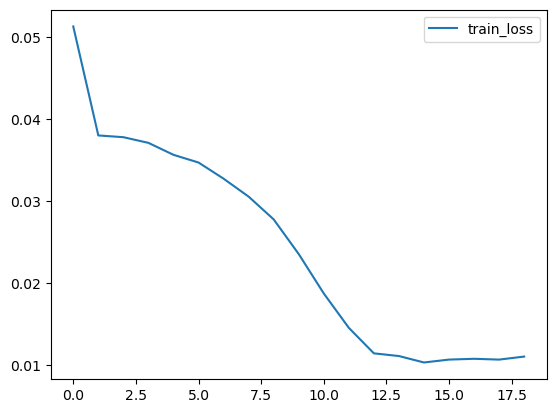

In [16]:
def plot_loss(loss_values):
    plt.plot(loss_values, label='train_loss')
    plt.legend()
    plt.show()

plot_loss(epoch_loss_list)

In [52]:
def calc_roc(model, data_loader, device):

    soft_preds = []
    y_true = []
    
    with torch.no_grad():
        #for i, (xx, yy_true, file_name) in enumerate(data_loader, start=1):
        for i, (input_images, labels, file_name) in enumerate(data_loader, start=1):
            input_images = input_images.to(device)
            labels = labels.to(device)
            predictions = model(input_images)
            for a in labels:
                y_true.append(a.item())
            yy_pred = F.softmax(model(input_images), dim=1)
            
            for b in yy_pred:
                soft_preds.append(b[1].item())

    roc = roc_auc_score(y_true, soft_preds)
    print(f"AUC Score: {roc}")
    return y_true, soft_preds, roc

y_true, soft_preds, roc = calc_roc(model, val_loader, device)

fpr_vgg, tpr_vgg, _ = roc_curve(y_true, soft_preds)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

AUC Score: 0.7003676470588236


**Idea**: is to extract features from the last layer of VGG and merge them with one more feature `ExpCDR` (a shallow attempt at multi-modal and early fusion) from dataset and build a random forest model to see of it improves the performance.

In [53]:
loaded_model = vgg_with_mul_fc_model()
loaded_model.load_state_dict(torch.load('/kaggle/working/model_fc'))

loaded_model.classifier[6] = nn.Sequential(*list(loaded_model.classifier[-1][:-4]))
loaded_model.to(device)
print("")

In [54]:
def extract_features(model, dataloader, device):
    model.eval()
    model.to(device)
    features = []
    labels = []
    filenames = []
    
    with torch.no_grad():
        for transformed_image_arr, label, file_name in dataloader:
            transformed_image_arr = transformed_image_arr.to(device)
            feat = model(transformed_image_arr).cpu().detach().numpy()
            features.append(feat)
            labels.append(label)
            filenames.append(file_name)
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    filenames = np.concatenate(filenames)
    
    df = pd.DataFrame(features, columns=['col'+str(i) for i in range(1,17)])
    df['labels'] = labels
    df['Filename'] = filenames
    return df

In [55]:
train_feat_df = extract_features(loaded_model, train_loader, device)
val_feat_df = extract_features(loaded_model, val_loader, device)

print(f'train_feat_df shape:{train_feat_df.shape}; val_feat_df shape :{val_feat_df.shape}')


train_feat_df shape:(520, 18); val_feat_df shape :(130, 18)


In [56]:
final_df = pd.concat([train_feat_df, val_feat_df])
final_df.to_csv('/kaggle/working/train_val_merged_features.csv', index=None)

In [57]:
new_df = pd.merge(g_df[['Filename', 'ExpCDR']], final_df, on='Filename')
new_df.to_csv('/kaggle/working/feat_cdr_merged.csv', index=None)

In [58]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, auc, plot_roc_curve, f1_score

In [66]:
data.head()

,Filename,ExpCDR,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,labels
0,001.jpg,0.7097,-12.344768,11.144770,-13.259173,-9.507957,25.232338,2.335801,13.217331,5.346053,4.542989,-10.338848,13.941782,-10.334948,-0.876711,-1.695242,-1.239383,7.919461,0
1,002.jpg,0.6953,-14.514392,13.083538,-15.585200,-11.150517,29.658804,2.782456,15.565176,6.246375,5.340096,-12.190336,16.400036,-12.225143,-1.055788,-2.021862,-1.446364,9.328690,0
2,003.jpg,0.9629,-8.766406,7.953094,-9.425519,-6.714830,17.883556,1.650188,9.285648,3.793449,3.209565,-7.246210,9.917375,-7.257595,-0.511399,-1.196467,-0.823458,5.650083,0
3,004.jpg,0.7246,-16.655756,15.038650,-17.909573,-12.788219,34.008743,3.193240,17.771345,7.135436,6.114992,-13.893764,18.795720,-13.981623,-1.201326,-2.356476,-1.596350,10.683192,0
4,005.jpg,0.6138,-17.299494,15.563346,-18.579397,-13.239309,35.179394,3.269503,18.334232,7.455018,6.329190,-14.364299,19.441177,-14.436363,-1.182200,-2.389426,-1.583462,11.109081,0


In [77]:
data = pd.read_csv('/kaggle/working/feat_cdr_merged.csv')
X_image_only = data.drop(['labels','Filename'], axis=1)
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X_image_only, y, test_size=0.2, stratify=y, random_state=42)

#rf = RandomForestClassifier(n_estimators=10,max_depth=2, random_state=42)
params = {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 2}
rf = RandomForestClassifier(**params)

rf.fit(X_train, y_train)

train_acc = accuracy_score(y_train, rf.predict(X_train))
val_acc = accuracy_score(y_test, rf.predict(X_test))

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {val_acc}")

y_pred_train = rf.predict_proba(X_train)[:, 1]
fpr_im_train, tpr_im_train, _ = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_im_train, tpr_im_train)
print(f"Train AUROC: {roc_auc_train}")

y_pred_test = rf.predict_proba(X_test)[:, 1]
fpr_im_test, tpr_im_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_im_test, tpr_im_test)
print(f"Test AUROC: {roc_auc_test}")

target_names = ['class 0', 'class 1']
print("\n",classification_report(y_test, y_pred, target_names=target_names))

Train Accuracy: 0.9326923076923077
Test Accuracy: 0.9230769230769231
Train AUROC: 0.9620002320006186
Test AUROC: 0.9420955882352942

               precision    recall  f1-score   support

     class 0       0.95      0.96      0.95        96
     class 1       0.88      0.85      0.87        34

    accuracy                           0.93       130
   macro avg       0.91      0.91      0.91       130
weighted avg       0.93      0.93      0.93       130



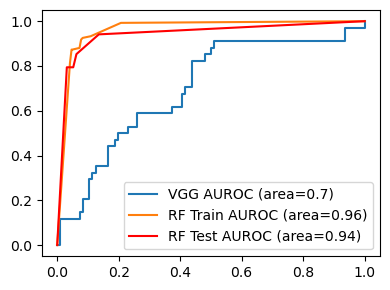

In [78]:
fig,ax = plt.subplots(figsize=(4,3))

ax.plot(fpr_vgg, tpr_vgg, label=f"VGG AUROC (area={round(roc_auc_vgg, 2)})")
ax.plot(fpr_im_train, tpr_im_train, label=f"RF Train AUROC (area={round(roc_auc_train, 2)})")
ax.plot(fpr_im_test, tpr_im_test, label=f"RF Test AUROC (area={round(roc_auc_test, 2)})", color='red')

ax.legend()
fig.tight_layout()
plt.show()

In [74]:
param_grid = {
             'bootstrap': [True, False],
             'max_depth': [1, 2, 3, 5, 8, 10],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [2, 4, 5, 10],
             #'min_samples_split': [1, 2, 5, 10],
             'n_estimators': [1, 2, 3, 4, 5, 8, 10]
             }

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Mean cross-validation score: {grid_search.best_score_:.3f}')

Best hyperparameters: {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 2}
Mean cross-validation score: 0.935
